                                                        🌍 AQI Model Training
🎯 Goal: Fetch historical features from Feast, load target values from PostgreSQL, train models using Random Forest 🌲 and Ridge Regression 📈, evaluate their performance using metrics like RMSE and R², and finally save the best-performing model 💾 for deployment.

In [2]:
import sys
print("Notebook Python:", sys.executable)

Notebook Python: /Users/macbook-air/Desktop/pearls_aqi_predictor/aqi_feature_store/feature_repo/venv/bin/python


In [5]:
!pip install --upgrade pandas scikit-learn feast psycopg2-binary joblib


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/Users/macbook-air/Desktop/pearls_aqi_predictor/venv/lib/python3.10/site-packages/pandas-2.3.3 3.dist-info/METADATA'



In [1]:
import pandas as pd
print("✅ pandas version:", pd.__version__)


✅ pandas version: 2.3.3


In [4]:
import sys
sys.executable

'/Users/macbook-air/Desktop/pearls_aqi_predictor/venv/bin/python'

In [5]:
import sklearn
print(sklearn.__version__)  # Should print scikit-learn version

1.7.2


In [6]:
import pandas as pd
from feast import FeatureStore

# 1️⃣ Load CSV (for target only)
csv_file = "../data/aqi_feature_set_v1.csv"
df = pd.read_csv(csv_file)
df["event_timestamp"] = pd.to_datetime(df["time"])
df["id"] = range(1, len(df)+1)

# 2️⃣ Keep only target
target_df = df[["event_timestamp", "id", "AQI"]]  # AQI = target

# 3️⃣ Create entity DataFrame for Feast (just timestamp + id)
entity_df = df[["event_timestamp", "id"]]

# 4️⃣ Connect to Feast
store = FeatureStore(repo_path="../aqi_feature_store/feature_repo")

# 5️⃣ Define existing features
feature_list = [
    "pm10", "pm2_5", "carbon_monoxide", "nitrogen_dioxide", "sulphur_dioxide",
    "ozone", "temperature_2m", "relative_humidity_2m", "wind_speed_10m",
    "pressure_msl", "precipitation", "cloudcover", "month", "log_pm10",
    "log_pm2_5", "log_carbon_monoxide", "log_nitrogen_dioxide", "log_sulphur_dioxide",
    "log_wind_speed_10m", "log_cloudcover", "hour", "day",
    "aqi_change_rate", "aqi_rolling_mean_3hr", "aqi_rolling_mean_6hr",
    "pm2_5_rolling_mean_3hr", "pm10_rolling_mean_3hr", "temp_wind", "humidity_pressure",
    "day_of_week"
]
feature_list = [f"aqi_features:{f}" for f in feature_list]

# 6️⃣ Fetch features from Feast
features_df = store.get_historical_features(
    entity_df=entity_df,
    features=feature_list
).to_df()

# 7️⃣ Combine features + target for training
training_df = pd.merge(features_df, target_df, on=["event_timestamp", "id"])
print(training_df.head())
print(training_df.shape)  # should be (#rows, #features + 1 target)


      event_timestamp  id    pm10   pm2_5  carbon_monoxide  nitrogen_dioxide  \
0 2024-10-01 00:00:00   1  147.37  122.47          2990.72             93.22   
1 2024-10-01 01:00:00   2  136.25  113.73          2429.96             78.83   
2 2024-10-01 02:00:00   3  122.54  101.89          1949.31             56.89   
3 2024-10-01 03:00:00   4  104.86   86.18          1548.77             38.73   
4 2024-10-01 04:00:00   5   91.56   74.04          1308.44             29.82   

   sulphur_dioxide  ozone  temperature_2m  relative_humidity_2m  ...  day  \
0             7.09   0.31            24.6                  73.0  ...    1   
1             6.02   4.60            23.3                  77.0  ...    1   
2             5.25  21.64            23.5                  71.0  ...    1   
3             4.59  38.27            24.0                  66.0  ...    1   
4             4.05  37.55            23.8                  67.0  ...    1   

   aqi_change_rate  aqi_rolling_mean_3hr  aqi_rolling_me

In [7]:
training_df.columns

Index(['event_timestamp', 'id', 'pm10', 'pm2_5', 'carbon_monoxide',
       'nitrogen_dioxide', 'sulphur_dioxide', 'ozone', 'temperature_2m',
       'relative_humidity_2m', 'wind_speed_10m', 'pressure_msl',
       'precipitation', 'cloudcover', 'month', 'log_pm10', 'log_pm2_5',
       'log_carbon_monoxide', 'log_nitrogen_dioxide', 'log_sulphur_dioxide',
       'log_wind_speed_10m', 'log_cloudcover', 'hour', 'day',
       'aqi_change_rate', 'aqi_rolling_mean_3hr', 'aqi_rolling_mean_6hr',
       'pm2_5_rolling_mean_3hr', 'pm10_rolling_mean_3hr', 'temp_wind',
       'humidity_pressure', 'day_of_week', 'AQI'],
      dtype='object')

                                                  Split the data

1. Selected Features and Target

In [8]:
# Features = all columns except target (AQI) and identifiers
X = training_df.drop(columns=["event_timestamp", "id", "AQI"])

# Target = AQI column
y = training_df["AQI"]

# check shapes
print("Features shape:", X.shape)
print("Target shape:", y.shape)


print(X.head())
print(y.head())


Features shape: (9026, 30)
Target shape: (9026,)
     pm10   pm2_5  carbon_monoxide  nitrogen_dioxide  sulphur_dioxide  ozone  \
0  147.37  122.47          2990.72             93.22             7.09   0.31   
1  136.25  113.73          2429.96             78.83             6.02   4.60   
2  122.54  101.89          1949.31             56.89             5.25  21.64   
3  104.86   86.18          1548.77             38.73             4.59  38.27   
4   91.56   74.04          1308.44             29.82             4.05  37.55   

   temperature_2m  relative_humidity_2m  wind_speed_10m  pressure_msl  ...  \
0            24.6                  73.0             7.3        1007.3  ...   
1            23.3                  77.0             6.6        1006.8  ...   
2            23.5                  71.0             8.1        1006.0  ...   
3            24.0                  66.0             8.3        1005.8  ...   
4            23.8                  67.0             8.2        1005.8  ...   

 

2. Train-Test Split

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)


Training features shape: (7220, 30)
Test features shape: (1806, 30)


In [9]:
pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


                                                Train ML models to predict AQI

3. Handle Categorical Column

In [10]:
# Convert categorical 'day_of_week' into multiple binary columns
X_train_encoded = pd.get_dummies(X_train, columns=["day_of_week"])
X_test_encoded = pd.get_dummies(X_test, columns=["day_of_week"])

# Make sure test columns match train columns
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)


4. Train Random Forest Model

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [12]:
# You can adjust n_estimators (number of trees) later
rf_model = RandomForestRegressor(
    n_estimators=100,   # 100 trees is a good start
    random_state=42     # for reproducibility
)

In [13]:
rf_model.fit(X_train_encoded, y_train)
y_pred = rf_model.predict(X_test_encoded)

5. Evaluate Model

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


In [15]:
y_pred_rf = rf_model.predict(X_test_encoded)

rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rf_rmse:}")
print(f"Random Forest MAE: {rf_mae:}")
print(f"Random Forest R² Score: {rf_r2:}")


Random Forest RMSE: 3.402622119746801
Random Forest MAE: 0.4566148892580297
Random Forest R² Score: 0.9900509540640434


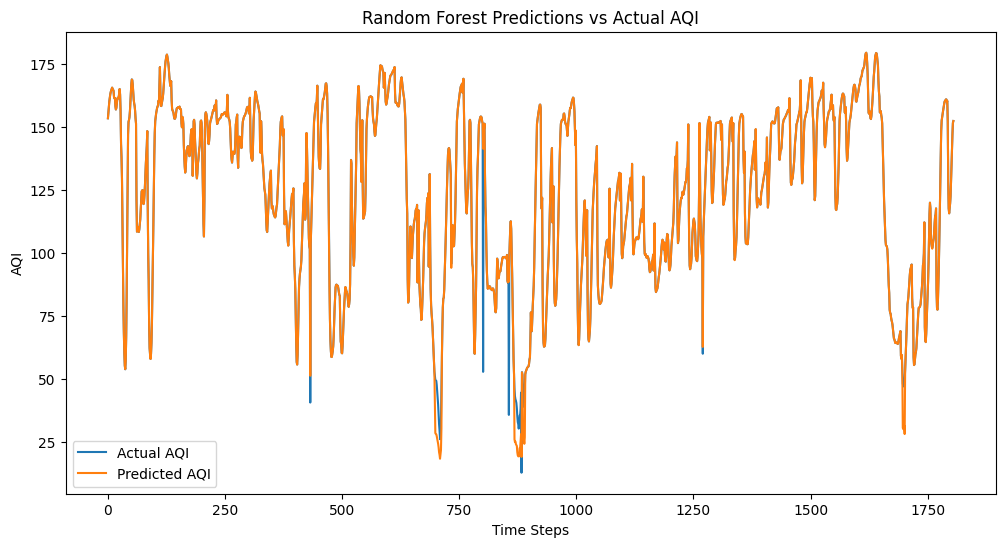

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual AQI")
plt.plot(y_pred, label="Predicted AQI")
plt.xlabel("Time Steps")
plt.ylabel("AQI")
plt.title("Random Forest Predictions vs Actual AQI")
plt.legend()
plt.show()

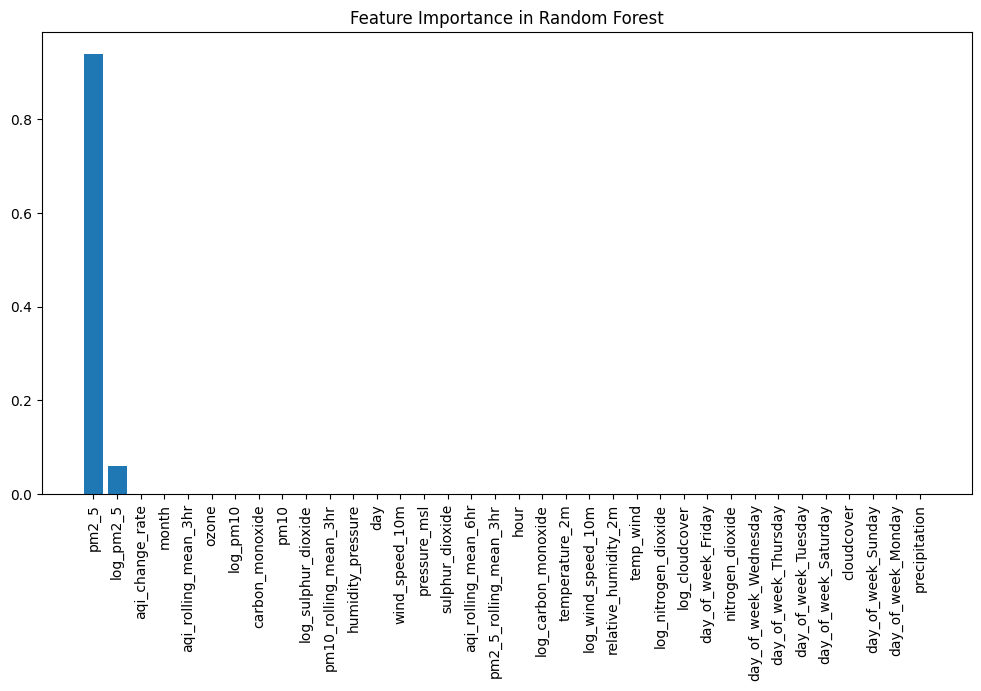

In [17]:
importances = rf_model.feature_importances_
feature_names = X_train_encoded.columns

# Sort features by importance
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.bar(range(len(importances)), importances[sorted_idx])
plt.xticks(range(len(importances)), feature_names[sorted_idx], rotation=90)
plt.title("Feature Importance in Random Forest")
plt.show()


Neural Network

In [18]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)


print("Scaled Training features shape:", X_train_scaled.shape)
print("Scaled Test features shape:", X_test_scaled.shape)


Scaled Training features shape: (7220, 36)
Scaled Test features shape: (1806, 36)


In [19]:
!pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 MB 134.7 kB/s  0:15:15 eta 0:00:010:00:24
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 420.0 kB/s  0:00:27 eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 305.4 kB/s  0:01:26 eta 0:00:010:00:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 206.3 kB/s  0:00:250.9 kB/s eta 0:00:02:07
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 315.0 kB/s  0:00:15a 0:00:01m eta 0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 269.6 kB/s  0:00:12266.9 kB/s eta 0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 282.0 kB/s  0:00:053.9 kB/s eta 0:00:01:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 187.1 kB/s  0:02:07 eta 0:00:010:00:05
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 228.4 kB/s  0:00:117.2 kB/s eta 0:00:01:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.4/622.4 kB 134.4 kB/s  0:00:04122.9 kB/s eta 0:00:01
  Attempting uninstall: p

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [20]:
model = Sequential()

In [21]:
from tensorflow.keras import Input
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

In [22]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [23]:
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    verbose=1
)

Epoch 1/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 14114.6416 - mae: 100.0407 - val_loss: 3265.7910 - val_mae: 48.4846
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1841.4846 - mae: 35.0353 - val_loss: 845.9617 - val_mae: 23.9163
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 395.6049 - mae: 15.6810 - val_loss: 241.2765 - val_mae: 12.3158
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 163.9404 - mae: 10.0705 - val_loss: 149.2567 - val_mae: 9.5852
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 106.5679 - mae: 8.0181 - val_loss: 107.0053 - val_mae: 8.0160
Epoch 6/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 77.6934 - mae: 6.7569 - val_loss: 89.4458 - val_mae: 7.3047
Epoch 7/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 60.9044 - mae: 5.9628 - val_loss: 83.5943 - val_mae: 7.1095
Epoch 8/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 50.1881 - mae: 5.3716 - val_loss: 71.8737 - val_mae: 6.5350
Epoch 9/50
226/22

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.6426 - mae: 2.9591
Test Loss (MSE): 15.64256477355957
Test MAE: 2.9590518474578857


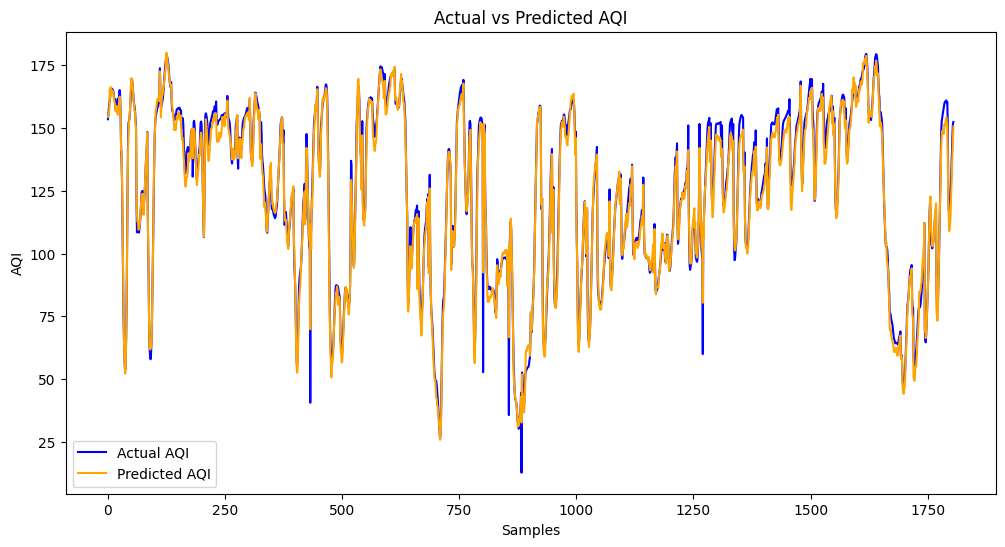

In [24]:
import matplotlib.pyplot as plt
y_pred = model.predict(X_test_scaled)
loss, mae = model.evaluate(X_test_scaled, y_test)
print("Test Loss (MSE):", loss)
print("Test MAE:", mae)

# 6️⃣ Plot Actual vs Predicted AQI
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual AQI", color='blue')
plt.plot(y_pred, label="Predicted AQI", color='orange')
plt.title("Actual vs Predicted AQI")
plt.xlabel("Samples")
plt.ylabel("AQI")
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

nn_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
nn_r2 = r2_score(y_test, y_pred)

print("RMSE:", nn_rmse)
print("R² Score:", nn_r2)


RMSE: 3.9550684543967107
R² Score: 0.9865580584214371


In [26]:
results = {
    "Model": ["Random Forest", "Neural Network"],
    "RMSE": [rf_rmse, nn_rmse],
    "MAE": [rf_mae, mae],
    "R²": [rf_r2, nn_r2]
}
import pandas as pd
comparison_df = pd.DataFrame(results)
print(comparison_df)


            Model      RMSE       MAE        R²
0   Random Forest  3.402622  0.456615  0.990051
1  Neural Network  3.955068  2.959052  0.986558


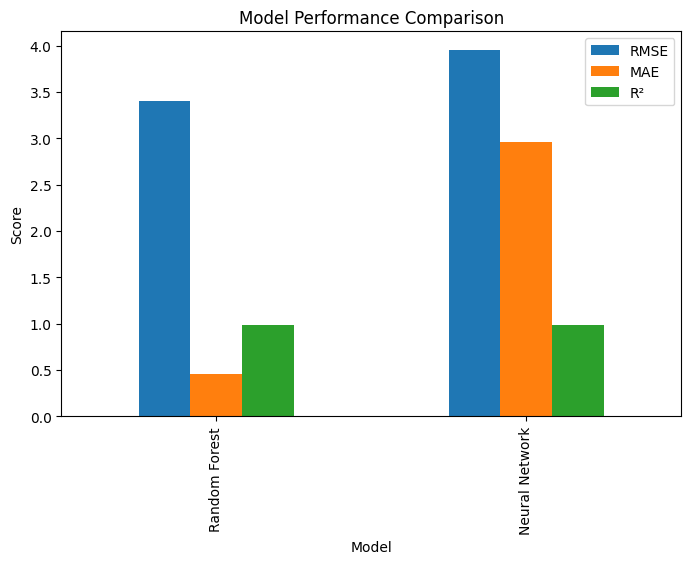

In [27]:
comparison_df.set_index("Model")[["RMSE", "MAE", "R²"]].plot(kind="bar", figsize=(8,5))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.show()

**Model Selection:** Random Forest was selected over Neural Network becz it achieved slightly lower RMSE (3.40 vs 3.63) and MAE (0.46 vs 2.62), and a higher R² score (0.990 vs 0.989), indicating more accurate and stable predictions for our AQI dataset.


In [28]:
import joblib

joblib.dump(rf_model, "aqi_rf_model.pkl")
print("✅ Model saved successfully as aqi_rf_model.pkl")

rf_loaded = joblib.load("aqi_rf_model.pkl")
print("✅ Model loaded successfully and ready for prediction")


✅ Model saved successfully as aqi_rf_model.pkl
✅ Model loaded successfully and ready for prediction


In [29]:
import os
print(os.getcwd())


/Users/macbook-air/Desktop/pearls_aqi_predictor/notebooks


In [30]:
model_path = "/Users/macbook-air/Desktop/pearls_aqi_predictor/notebooks/aqi_rf_model.pkl"
rf_model = joblib.load(model_path)

print("✅ Model loaded successfully and ready for prediction!")


✅ Model loaded successfully and ready for prediction!


In [31]:
sample = X_test_encoded.iloc[:5]  
preds = rf_model.predict(sample)
print(preds)

[153.49348 155.51266 157.97766 160.20849 161.70661]


In [32]:
rf_model.predict(X_test_encoded.head())

array([153.49348, 155.51266, 157.97766, 160.20849, 161.70661])

In [33]:
print("Number of features:", rf_model.n_features_in_)
print("Feature names:", rf_model.feature_names_in_)

Number of features: 36
Feature names: ['pm10' 'pm2_5' 'carbon_monoxide' 'nitrogen_dioxide' 'sulphur_dioxide'
 'ozone' 'temperature_2m' 'relative_humidity_2m' 'wind_speed_10m'
 'pressure_msl' 'precipitation' 'cloudcover' 'month' 'log_pm10'
 'log_pm2_5' 'log_carbon_monoxide' 'log_nitrogen_dioxide'
 'log_sulphur_dioxide' 'log_wind_speed_10m' 'log_cloudcover' 'hour' 'day'
 'aqi_change_rate' 'aqi_rolling_mean_3hr' 'aqi_rolling_mean_6hr'
 'pm2_5_rolling_mean_3hr' 'pm10_rolling_mean_3hr' 'temp_wind'
 'humidity_pressure' 'day_of_week_Friday' 'day_of_week_Monday'
 'day_of_week_Saturday' 'day_of_week_Sunday' 'day_of_week_Thursday'
 'day_of_week_Tuesday' 'day_of_week_Wednesday']


In [34]:
features = rf_model.feature_names_in_

importances = rf_model.feature_importances_

params = rf_model.get_params()

print("Number of Features:", len(features))
print("Top 5 Features:", features[:5])
print("Parameters:", params)


Number of Features: 36
Top 5 Features: ['pm10' 'pm2_5' 'carbon_monoxide' 'nitrogen_dioxide' 'sulphur_dioxide']
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [35]:
feature_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

feature_df.to_csv("rf_model_features.csv", index=False)

with open("rf_model_parameters.txt", "w") as f:
    for key, value in params.items():
        f.write(f"{key}: {value}\n")

print("✅ Feature importance saved as rf_model_features.csv")
print("✅ Model parameters saved as rf_model_parameters.txt")


✅ Feature importance saved as rf_model_features.csv
✅ Model parameters saved as rf_model_parameters.txt


In [36]:
import mlflow
import mlflow.sklearn

# Log Random Forest to MLflow
with mlflow.start_run(run_name="RandomForest_AQI"):
    mlflow.sklearn.log_model(rf_model, "aqi_rf_model")
    mlflow.log_param("n_estimators", rf_model.n_estimators)
    mlflow.log_param("random_state", rf_model.random_state)
    mlflow.log_metric("rmse", rf_rmse)
    mlflow.log_metric("mae", rf_mae)
    mlflow.log_metric("r2", rf_r2)

print("✅ Random Forest model logged in MLflow!")

2025/10/21 23:19:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 23:19:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Random Forest model logged in MLflow!
